## Cleaning TV2 & DR datasets and basic statistics

In [1]:
import requests
import time
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import tqdm
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns


### Import datasets

In [2]:
# Import TV2 dataset
tv2 = pd.read_csv('articles_tv2.csv')
display(len(tv2))

8758

In [3]:
dr = pd.read_csv('dr_articles.csv')
display(len(dr))

2065

TV2: The raw dataset after scraping websites from links has 8758 articles.

DR: The raw dataset after scraping websites from links has 2065 articles. 

### Diverse cleaning operations

#### TV2 Dataset

In [4]:
## Rows that stem from links to a search page. They have the title "Søg på TV 2" and can be deleted
tv2 = tv2[tv2.titles != 'Søg på TV 2'].reset_index(drop = True)
# After this step, 7416 observations remain
# In the next step we drop all rows that do not contain values. These are sports artciles like this one: https://sport.tv2.dk/2012-02-26-sur-s%C3%B8d-fornemmelse-hos-kasper-hvidt
tv2 = tv2.dropna(subset = ['content'])
# Rename column
tv2.rename(columns = {'tv2':'source'}, inplace = True)
# Reset index
tv2 = tv2.reset_index(drop = True)
# Change date to date_time objects
tv2['date'] = pd.to_datetime(tv2['date'])
# Drop articles published outside period of interest (2012-2022)
tv2 = tv2[tv2['date'].dt.year >= 2012]
len(tv2)

6794

Number of observations and rows: TV2 dataset now contains 6794 articles 

#### DR Dataset

We found 538 observations for which no content was retrieved. These include articles with a different HTML structure (see, e.g.: 'https://www.dr.dk/nyheder/region-ingen-fare-patienter-paa-holbaek-sygehus?focusId=3406239'). Unfortunately, our scraping code did not account for this structure. If we had more time, we would go back, adapt the code and get the content of these articles. For the purpose of this limited analysis, we continue without those articles.

In [5]:
dr = dr.dropna(subset = ["content"]).reset_index(drop = True)

In [6]:
dr['date'] = pd.to_datetime(dr['date'])
dr = dr[dr['date'].dt.year >= 2012].copy()
len(dr)

1523

After dropping observations without content, 1523 articles remain.

#### Columns of DR and TV datasets: 
* `titles` contains the articles' title
* `sub_header` contains the articles' subheader
* `h2` contains any headline found in the article 
* `author` contains the author of the article 
* `tag` contains any tags that TV2 added to the article: e.g. "udland". 
* `source` will later indicate the source 
* `links` contains the link to the original article
* `date` contains date in the datetime formate

#### Cleaning articles' content

In [7]:
def cleaning_texts(df):
    '''
    Function cleans the text of the "content", "titles", "subheaders" and "h2" columns of TV2 and DR datasets.
    '''
    df_new = df.copy()
    for i in tv2[['titles', 'sub_header', 'h2', 'content', 'author']]:
        df_new[i] = df_new[i].str.lower()\
            .str.replace('\r', '')\
            .str.replace('\n', '')\
            .str.replace('\xa0', '')
    return df_new

In [8]:
# Cleaning datasets with cleaning function
tv2 = cleaning_texts(tv2)
dr = cleaning_texts(dr)

### Creating more relevant datasets

Creating different DataFrames according to the number of times "sygeplej*" is found in the articles' content. The more frequently the term features in the text, the more relevant the articles' should be for our analysis. 

_For now, we continue working with data in which "sygeplej*" appears at least twice_.

In [9]:
### Defining function

In [10]:
# Create different datasets with "sygeplej*" featuring at least X times in the text
def sygeplej_count(df):
    df_sygeplej1x = df[df['content'].str.count("sygeplej") >= 1]
    df_sygeplej2x = df[df['content'].str.count("sygeplej") >= 2]
    df_sygeplej3x = df[df['content'].str.count("sygeplej") >= 3]
    df_sygeplej4x = df[df['content'].str.count("sygeplej") >= 4]
    return df_sygeplej1x, df_sygeplej2x, df_sygeplej3x, df_sygeplej4x

In [11]:
tv2_sygeplej1x, tv2_sygeplej2x, tv2_sygeplej3x, tv2_sygeplej4x = sygeplej_count(tv2)
dr_sygeplej1x, dr_sygeplej2x, dr_sygeplej3x, dr_sygeplej4x = sygeplej_count(dr)

In [12]:
dict_sygeplej_count = {"sygeplej* count":\
                       ['At least once', 'At least twice', 'At least three times', 'More than three times'],\
                       "Num. of articles (TV2)" :\
                       [len(tv2_sygeplej1x), len(tv2_sygeplej2x), len(tv2_sygeplej3x), len(tv2_sygeplej4x)],\
                      "Num. of articles (DR)" :\
                       [len(dr_sygeplej1x), len(dr_sygeplej2x), len(dr_sygeplej3x), len(dr_sygeplej4x)]}

table_sygeplej_count = pd.DataFrame(data = dict_sygeplej_count)
display(table_sygeplej_count)

,sygeplej* count,Num. of articles (TV2),Num. of articles (DR)
0,At least once,3607,660
1,At least twice,1511,528
2,At least three times,909,458
3,More than three times,668,392


## Frequency of Articles by Date

In [108]:
def frequency_table(df):
    df['year']=pd.to_datetime(df["date"]).dt.year
    df['month']=pd.to_datetime(df["date"]).dt.month
    df_freq=df.copy()
    df_freq = df_freq.dropna(subset = ['year', 'month'])
    
    
    df_freq1, df_freq2, df_freq3, df_freq4=sygeplej_count(df_freq)
    
    freq1 = df_freq1.groupby(['year', 'month'])["content"].count()
    df_freq1x=pd.DataFrame(freq1).reset_index(drop=False)
    
    freq1.reset_index(drop=False)
    print(df_freq1x)
    freq2 = df_freq2.groupby(['year', 'month'])["content"].count()
    df_freq2x=pd.DataFrame(freq2).reset_index(drop=True)

    freq3 = df_freq3.groupby(['year', 'month'])["content"].count()
    df_freq3x=pd.DataFrame(freq3).reset_index(drop=True)
    
    freq4 = df_freq4.groupby(['year', 'month'])["content"].count()
    df_freq4x=pd.DataFrame(freq4).reset_index(drop=True)
  
      
    
    df_freq = pd.DataFrame([df_freq1x['year'].astype(str),df_freq1x['month'].astype(str), df_freq1x['content'] , df_freq2x['content'],\
                            df_freq3x['content'], df_freq4x['content']]).transpose()
    df_freq.columns=(['Year', "Month","At least once", "At least twice", "At least three times", "More than three times"])
    df_freq['Date']=df_freq['Year']+"-"+ df_freq['Month']
    
    return df_freq
tv2_freq_df=frequency_table(tv2)


     year  month  content
0    2012      1       14
1    2012      2       14
2    2012      3       50
3    2012      4       33
4    2012      5       18
..    ...    ...      ...
122  2022      3       25
123  2022      4       14
124  2022      5       14
125  2022      6       11
126  2022      7       34

[127 rows x 3 columns]


In [109]:
tv2_freq_df

,Year,Month,At least once,At least twice,At least three times,More than three times,Date
0,2012,1,14,3.0,3.0,3.0,2012-1
1,2012,2,14,7.0,3.0,3.0,2012-2
2,2012,3,50,32.0,14.0,8.0,2012-3
3,2012,4,33,8.0,3.0,2.0,2012-4
4,2012,5,18,6.0,2.0,4.0,2012-5
...,...,...,...,...,...,...,...
122,2022,3,25,3.0,NaN,NaN,2022-3
123,2022,4,14,15.0,NaN,NaN,2022-4
124,2022,5,14,NaN,NaN,NaN,2022-5
125,2022,6,11,NaN,NaN,NaN,2022-6


In [ ]:
year_month=[]
    for year in range(2012,2023):
        for month in ["jan", "feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "okt", "nov", "dec"]:
            _=f'{year} {month}'
            year_month.append(_)
    year_month=year_month[0:-4]
    date=pd.DataFrame(year_month) 

In [107]:
tv2_freq_df


,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
Year,2012,2012,2012,2012,2012,2012,2012,2012,2012,2012,...,2021,2021,2021,2022,2022,2022,2022,2022,2022,2022
Month,1,2,3,4,5,6,7,8,9,10,...,10,11,12,1,2,3,4,5,6,7
At least once,14,14,50,33,18,12,26,27,18,25,...,40,71,42,31,32,25,14,14,11,34
At least twice,3.0,7.0,32.0,8.0,6.0,5.0,2.0,8.0,7.0,11.0,...,8.0,18.0,4.0,8.0,1.0,3.0,15.0,NaN,NaN,NaN
At least three times,3.0,3.0,14.0,3.0,2.0,4.0,2.0,6.0,2.0,5.0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
More than three times,3.0,3.0,8.0,2.0,4.0,2.0,4.0,2.0,4.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,2012-1,2012-2,2012-3,2012-4,2012-5,2012-6,2012-7,2012-8,2012-9,2012-10,...,2021-10,2021-11,2021-12,2022-1,2022-2,2022-3,2022-4,2022-5,2022-6,2022-7


[(0.0, 80.0)]

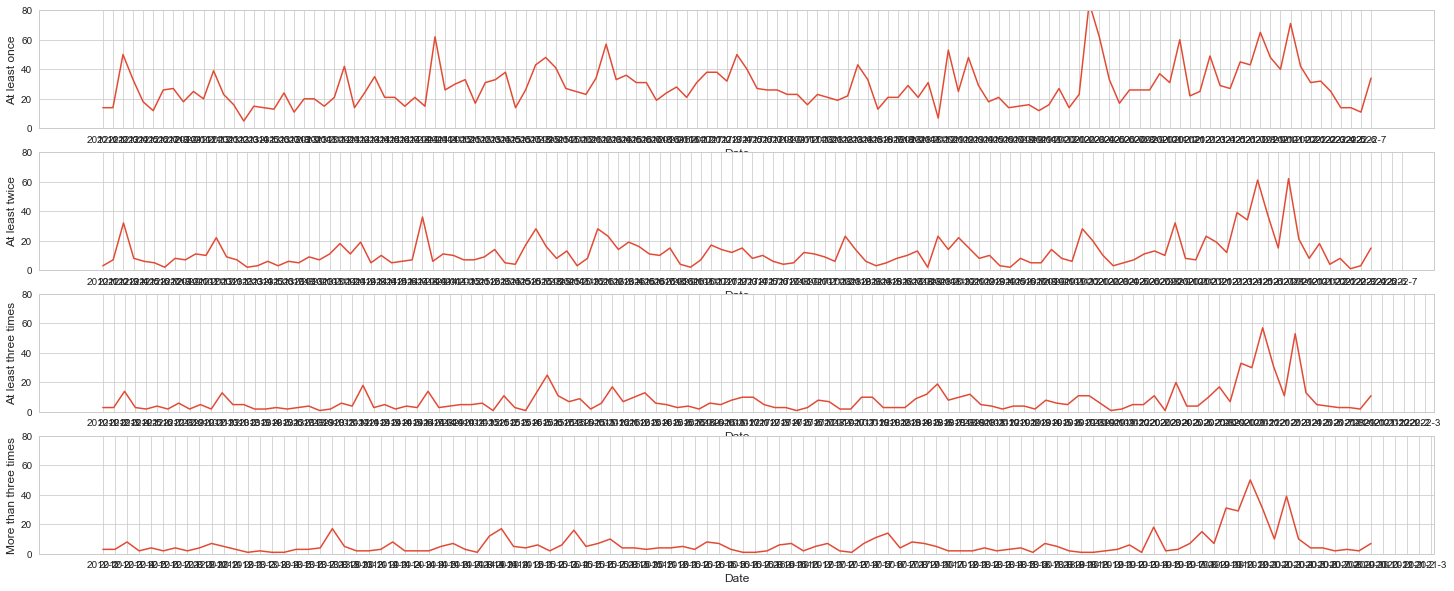

In [149]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=4, ncols=1, sharey=False, figsize=(25,10))

ax[0] = sns.lineplot(x = 'Date', y = "At least once", data=tv2_freq_df, ax=ax[0])
ax[0].set(ylim=(0, 80))
ax[1] = sns.lineplot(x = 'Date', y = "At least twice", data=tv2_freq_df, ax=ax[1])
ax[1].set(ylim=(0, 80))

ax[2] = sns.lineplot(x = 'Date', y = "At least three times", data=tv2_freq_df, ax=ax[2])
ax[2].set(ylim=(0, 80))

ax[3] = sns.lineplot(x = 'Date', y = "More than three times", data=tv2_freq_df, ax=ax[3])
ax[3].set(ylim=(0, 80))


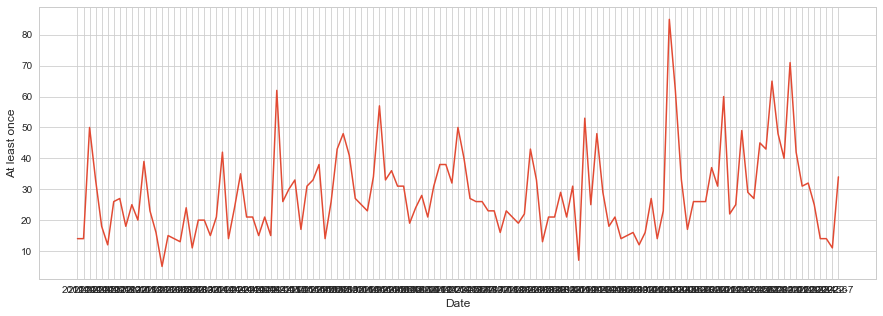

In [128]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(15,5))

ax = sns.lineplot(x = 'Date', y = "At least once", data=tv2_freq_df)



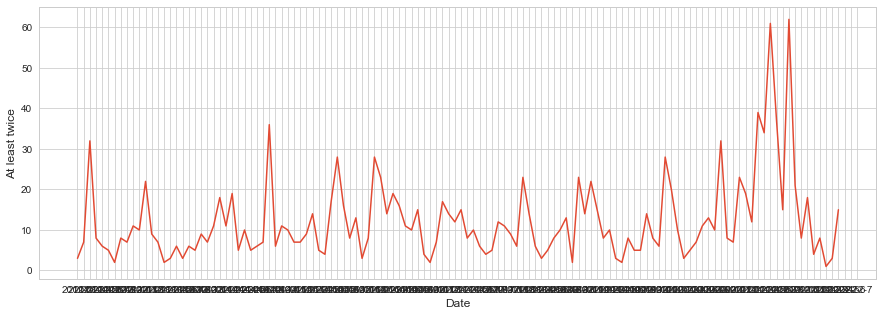

In [129]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(15,5))

ax = sns.lineplot(x = 'Date', y = "At least twice", data=tv2_freq_df)

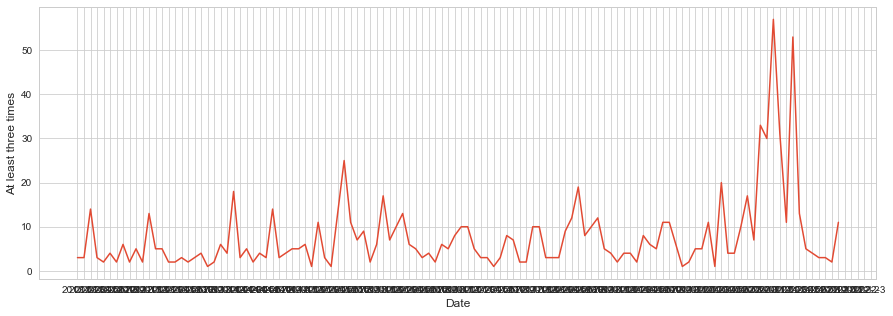

In [131]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(15,5))

ax = sns.lineplot(x = 'Date', y = "At least three times", data=tv2_freq_df)

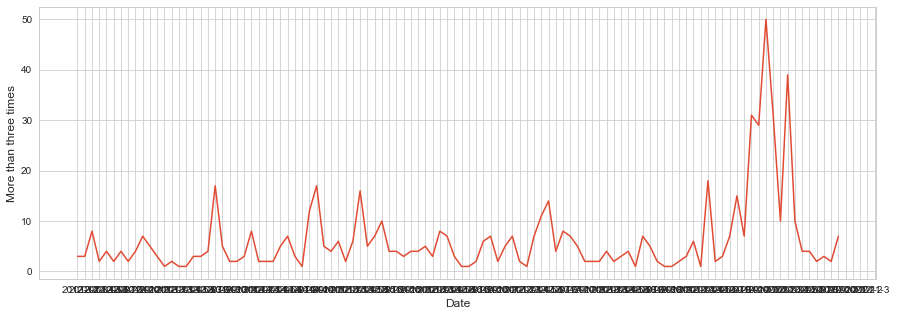

In [132]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(15,5))

ax = sns.lineplot(x = 'Date', y = "More than three times", data=tv2_freq_df)

In [15]:
tv2['year'] = pd.to_datetime(tv2_sygeplej2x["date"]).dt.year
tv2['month'] = pd.to_datetime(tv2_sygeplej2x["date"]).dt.month
tv2_freq = tv2.copy()
tv2_freq = tv2_freq.dropna(subset = ['year', 'month'])

In [16]:
tv2_freq = tv2.groupby(['year', 'month'])["content"].count()
tv2_freq_df = pd.DataFrame(tv2_freq).reset_index()
tv2_freq_df

,year,month,content
0,2012.0,1.0,3
1,2012.0,2.0,7
2,2012.0,3.0,32
3,2012.0,4.0,8
4,2012.0,5.0,6
...,...,...,...
119,2022.0,3.0,4
120,2022.0,4.0,8
121,2022.0,5.0,1
122,2022.0,6.0,3


In [17]:
tv2_freq_df['date']=tv2_freq_df['year'].astype(str)+tv2_freq_df['month'].astype(str)

In [18]:
tv2_freq

year    month
2012.0  1.0       3
        2.0       7
        3.0      32
        4.0       8
        5.0       6
                 ..
2022.0  3.0       4
        4.0       8
        5.0       1
        6.0       3
        7.0      15
Name: content, Length: 124, dtype: int64

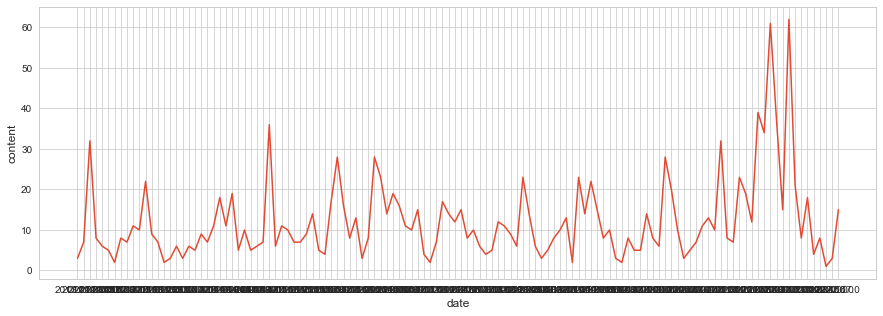

In [19]:
# Plotting count of tags
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(15,5))

ax = sns.lineplot(x = 'date', y = 'content', data= tv2_freq_df )

## Analysis of Tags

### Most frequent Tags

In [197]:
# Define tag-count function
def tag_count(df):
    df_tags=df["tag"].value_counts()
    df_tags=pd.DataFrame(df_tags).reset_index(drop=False)
    df_tags.columns=("tags", "count")
    return df_tags

# Call function
tv2_tags = tag_count(tv2_sygeplej2x)
dr_tags = tag_count(dr_sygeplej2x)

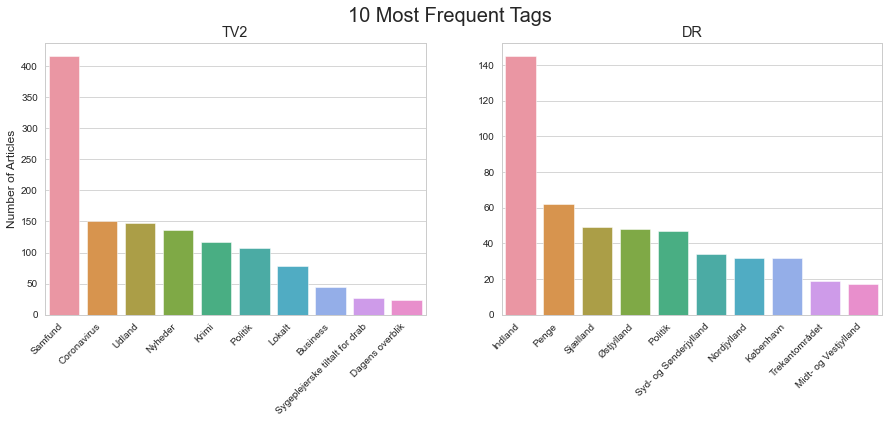

In [223]:
# Plotting count of tags
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))

ax[0] = sns.barplot(x = tv2_tags["tags"][0:10], y = tv2_tags["count"], orient ="v", ax = ax[0])
ax[1] = sns.barplot(x = dr_tags["tags"][0:10], y = dr_tags["count"], orient ="v", ax = ax[1])

_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')

_ = plt.suptitle("10 Most Frequent Tags", size = 20)
_ = ax[0].set_title("TV2")
_ = ax[1].set_title("DR")
_ = ax[0].set_ylabel("Number of Articles")
_ = ax[1].set_ylabel("")

_ = ax[0].set(xlabel=None)
_ = ax[1].set(xlabel=None)

### Usage of tags over time